<a href="https://colab.research.google.com/github/antonelijr/variant_D614G/blob/main/python_variant_D614G_EA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Epidemic Growth Rates and Transmissibility of SARS-CoV-2 - Europe x Asia**


## Estimation of the growth rate $\lambda$ and $\mathcal{R}_0$

Consider a exponential approximation for the initial segment of the growth function $I(t)$ of the epidemics (that is, $I(t)$ isthe numeber of infected per unit of time), with growth rate $\lambda$,
$$
 I(t)=I_0 \, e^{\lambda t}
$$

By transforming to logarithmic scale we have linear equation
$$
 \log I(t) = \log I_0 + \lambda t
$$
This suggests using a simple Linear Model
$$
 y = \alpha_0 + \alpha_1 x
$$
to estimate $\lambda$ as the slope $\alpha_1$ of a regression line.

The Basic Reproduction Number $\mathcal{R}_0$ may be estimated as
$$
 \mathcal{R}_0 = 1 + \alpha_1  \, \gamma^{-1}
$$
where $\gamma^{-1}$ is the average length of time someone is infectious.

In general, it is not possible to simultaneously estimate $\alpha_1$ and $\gamma$ from epidemic time series, since these are confounded parameters (that is only a combination of both can be estimated from epidemic time series). Hence, in order to estimate $\mathcal{R}_0$ from epidemic time series on need to obtain the value of $\gamma$ by other means. Various estimates range from 7 days to 10 days.

It is important to remark that, for the purpose of estimating the growth rate $\lambda$ at the initial times, it is possible to use any derivative or any integral of $I(t)$. In fact, since $I(t)$ is essentialy an exponential function, its derivatives and integrals are constant multiples of $I(t)$ (with distinct constnats). Hence, it does not matter if one uses the actual times series for $I(t)$ or the cumulative counting, the Linar Model for estimating $\lambda$ will have the same $\alpha_1$, with possibly distinct estimates of $\alpha_0$. Since we are only intrested in $\alpha_1$ this is imaterial. \\



## Load the necessary Python Libraries

In [ ]:
import sys
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd 
import random
import math
import time
import xgboost
import datetime
import operator
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from scipy.special import expit
from scipy.stats import norm
from scipy import stats


## Retreive and Load the Data
Read the data from git repositories.


In [ ]:
#confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
#deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/taimafuruyama/SARS_Cov_2/master/time_series_covid19_confirmed_US_STATES_TA_V4.csv')

## View Data 

In [ ]:
confirmed_df.head(n=5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,02/01/2020,02/02/2020,02/03/2020,02/04/2020,02/05/2020,02/06/2020,02/07/2020,02/08/2020,02/09/2020,02/10/2020,02/11/2020,02/12/2020,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,05/01/2020,05/02/2020,05/03/2020,05/04/2020,05/05/2020,05/06/2020,05/07/2020,05/08/2020,05/09/2020,05/10/2020,05/11/2020,05/12/2020,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
0,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831
1,NaN,NaN,NaN,NaN,NaN,NaN,Albania,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029
2,NaN,NaN,NaN,NaN,NaN,NaN,Algeria,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697
3,NaN,NaN,NaN,NaN,NaN,NaN,Andorra,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763
4,NaN,NaN,NaN,NaN,NaN,NaN,Angola,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70


In [ ]:
confirmed_df.tail(n=5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,02/01/2020,02/02/2020,02/03/2020,02/04/2020,02/05/2020,02/06/2020,02/07/2020,02/08/2020,02/09/2020,02/10/2020,02/11/2020,02/12/2020,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,05/01/2020,05/02/2020,05/03/2020,05/04/2020,05/05/2020,05/06/2020,05/07/2020,05/08/2020,05/09/2020,05/10/2020,05/11/2020,05/12/2020,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
261,NaN,NaN,NaN,NaN,NaN,NaN,Sao Tome and Principe,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23,174,174,187,208,208,208,208,208,220,235,235,235,235,246,251,251,251,251,251,251,299,441
262,NaN,NaN,NaN,NaN,NaN,NaN,Yemen,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12,22,25,25,34,34,51,56,65,70,85,106,122,128,130,167,184,197,209,212,222,233,249
263,NaN,NaN,NaN,NaN,NaN,NaN,Comoros,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,8,8,8,11,11,11,11,11,11,11,11,11,11,11,34,34,78,78,87,87,87
264,NaN,NaN,NaN,NaN,NaN,NaN,Tajikistan,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,15,15,76,128,230,293,379,461,522,612,612,661,729,801,907,1118,1322,1524,1729,1936,2140,2350,2551,2738,2929,3100,3266
265,NaN,NaN,NaN,NaN,NaN,NaN,Lesotho,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2


## Filter the approprite subset of World Countries

Select the countries of the East and West to create a new Data Frame

In [ ]:
last_column = list(confirmed_df.columns)[confirmed_df.shape[1]-1]
confirmed_df = confirmed_df[confirmed_df[last_column] != 0]
West = ['Belgium', 'Denmark', 'France', 'Germany', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'United Kingdom']
East = ['Australia', 'Bangladesh', 'China', 'India', 'Japan', 'Korea South', 'Singapore', 'Taiwan', 'Thailand', 'Vietnam']
confirmed_W_df = (confirmed_df[confirmed_df['Province_State'].isin(West)])
confirmed_E_df = (confirmed_df[confirmed_df['Province_State'].isin(East)])

Clean and reset the new Data Frames

In [ ]:
# Find the number of countries in each subset
length_confirmed_W =len(confirmed_W_df.Admin2)
length_confirmed_E =len(confirmed_E_df.Admin2)

# Reset the index labels
confirmed_W_df = confirmed_W_df.reset_index()
confirmed_E_df = confirmed_E_df.reset_index()

# Remove France-Saint_Barthelemy and France-Saint_Pierre_and_Miquelon
confirmed_W_df = confirmed_W_df.drop(confirmed_W_df.index[confirmed_W_df['Admin2']=="Saint Barthelemy"])
confirmed_W_df = confirmed_W_df.drop(confirmed_W_df.index[confirmed_W_df['Admin2']=="Saint Pierre and Miquelon"])

# Remove Hubei-China
confirmed_E_df = confirmed_E_df.drop(confirmed_E_df.index[confirmed_E_df['Admin2']=="Hubei"])


Fix the range of the time series.

In [ ]:
first_date_W = '2/15/20'
first_date_E = '1/22/20'
last_date = list(confirmed_df.columns)[confirmed_df.shape[1]-1]


Extract the time series within the range

In [ ]:
# Get the names of the columns for the definition of next Data Frame
cols_W = confirmed_W_df[['Province_State','Admin2']].fillna('Main').apply(lambda x: '-'.join(x), axis=1)
cols_E = confirmed_E_df[['Province_State','Admin2']].fillna('Main').apply(lambda x: '-'.join(x), axis=1)

# West
confirmed_W_df = confirmed_W_df.loc[:, first_date_W : last_date]

# East
confirmed_E_df = confirmed_E_df.loc[:, first_date_E : last_date]


Create new Data Frames with the counties as columns and the dates as rows

In [ ]:
# West
cum_W_df = confirmed_W_df.transpose().copy(deep=True)
cum_W_df.columns = cols_W
cum_W_df.columns = cum_W_df.columns.str.replace(' ', '_')
cols_W = cum_W_df.columns

# East
cum_E_df = confirmed_E_df.transpose().copy(deep=True)
cum_E_df.columns = cols_E
cum_E_df.columns = cum_E_df.columns.str.replace(' ', '_')
cols_E = cum_E_df.columns


Side by side plot the time series of each county

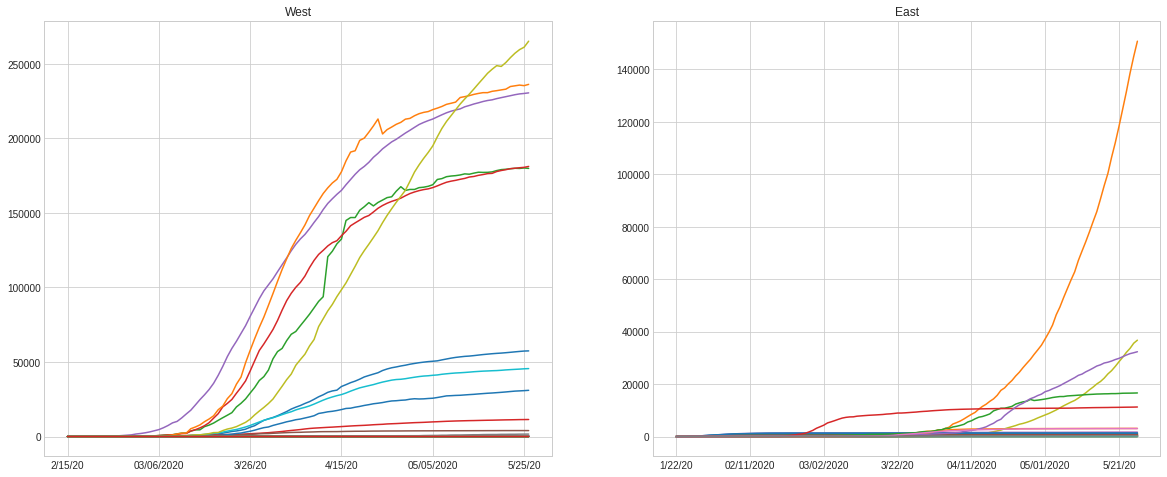

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
cum_W_df.plot(ax = axes[0],legend=False,title="West")
cum_E_df.plot(ax = axes[1],legend=False, title="East")


The time series from the repository are the cumulative counting.
In order to use the actual daily counting it is necessary to reverse the cumulative sum of the time series. Uncoment below to compute the daily counting. \\
**Obs:** as remarked before, for the purpose of estimating the growth rate for the initial segment of the epidemics growth, it is possible to use the cumulative countig instead of the daily counting.

In [ ]:
# Uncomnt below to reverse the cumulative time series

# West
total_W_df = cum_W_df.copy(deep=True)
total_W_df.loc[:, cols_W ] = total_W_df.loc[:, cols_W ].diff().fillna(0).astype(int)

# East
total_E_df = cum_E_df.copy(deep=True)
total_E_df.loc[:, cols_E ] = total_E_df.loc[:, cols_E ].diff().fillna(0).astype(int)


## Transform the data to Logarithmic Scale

Apply logarithm transformation the time series

In [ ]:
# West
log_cum_W_df = cum_W_df.apply(np.log).replace([np.inf, -np.inf], 0).copy(deep=True)
log_W_df = total_W_df.apply(np.log).replace([np.inf, -np.inf], 0).copy(deep=True)

# East
log_cum_E_df = cum_E_df.apply(np.log).replace([np.inf, -np.inf], 0).copy(deep=True)
log_E_df = total_E_df.apply(np.log).replace([np.inf, -np.inf], 0).copy(deep=True)


Side by side plot of the (initial segment) log transformed time series

(0.0, 50.0)

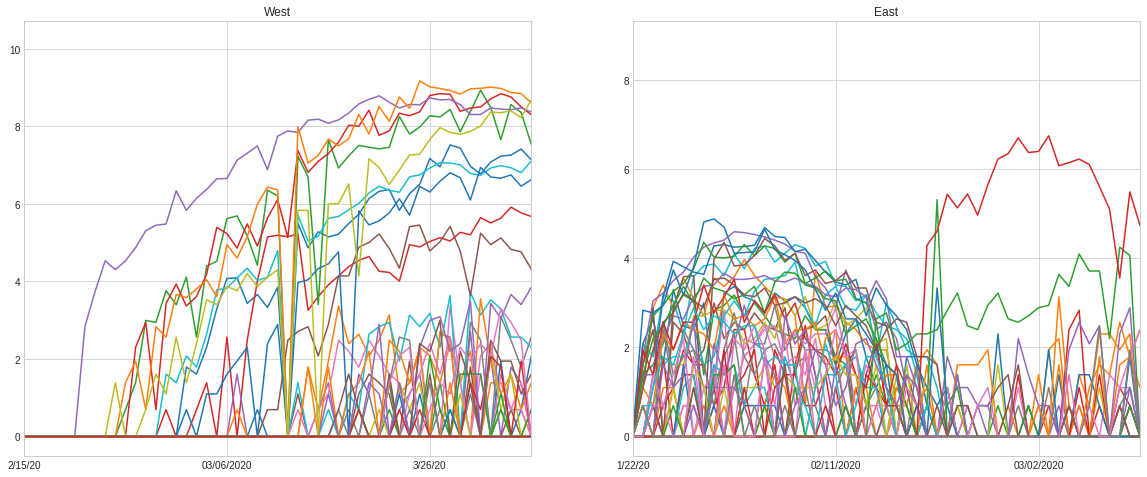

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
lwp = log_W_df.plot(ax = axes[0],legend=False,title="West")
lep = log_E_df.plot(ax = axes[1],legend=False,title="East")
lwp.set_xlim(0,50)
lep.set_xlim(0,50)

## Computation Linear Models
Define initial segment of time series

In [ ]:
# We consider an initial segment of 3 weeks
num_days = 21
x = np.arange(num_days, dtype=float).reshape((num_days, 1))

Example of Linear Model computation

In [ ]:
test_W = 'Portugal-Main'
test_E = 'Taiwan-Main'
start_W = log_W_df.index.get_loc(log_W_df[test_W].ne(0).idxmax())
start_E = log_E_df.index.get_loc(log_E_df[test_E].ne(0).idxmax())
y_W = log_cum_W_df[test_W][start_W:start_W+num_days]
y_E = log_cum_E_df[test_E][start_E:start_E+num_days]


Compute Linear Models using standard regression

In [ ]:
lm_W = LinearRegression().fit(x,y_W)
lm_E = LinearRegression().fit(x,y_E)


Plot the Linear Model fitting

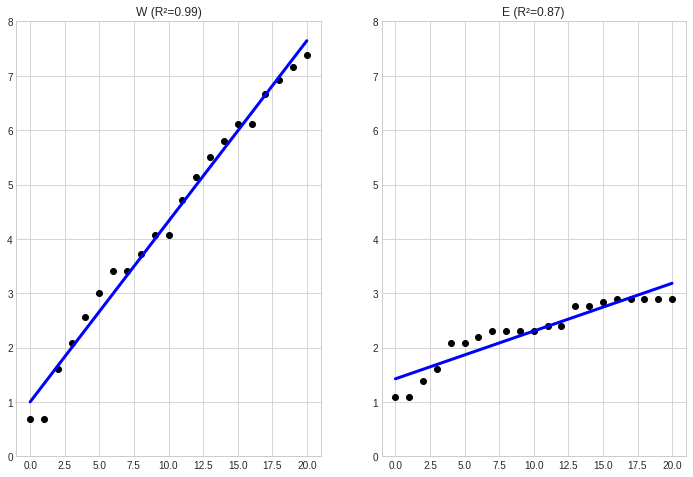

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
plt.title('W'+" (R²="+'%.2f' % r2_score(y_W,lm_W.predict(x))+")")
plt.ylim(0,8)
plt.plot(x, lm_W.predict(x), color='blue', linewidth=3)
plt.scatter(x, y_W,  color='black')

plt.subplot(1, 2, 2)
plt.title('E'+" (R²="+'%.2f' % r2_score(y_E,lm_E.predict(x))+")")
plt.ylim(0,8)
plt.plot(x, lm_E.predict(x), color='blue', linewidth=3)
plt.scatter(x, y_E,  color='black')


## Computation of summary statistics of Linear Model

In [ ]:
# Function for the computation of summary statistics 
def lm_summary(y):
  number_days=len(y)
  x = np.arange(number_days, dtype=float).reshape((number_days, 1))
  lm = LinearRegression().fit(x,y)
  params = np.append(lm.intercept_,lm.coef_)
  predictions = lm.predict(x)
  newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
  MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
  var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
  sd_b = np.sqrt(var_b)
  ts_b = params/ sd_b
  p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]
  #sd_b = np.round(sd_b,4)
  #ts_b = np.round(ts_b,4)
  #p_values = np.round(p_values,6)
  #params = np.round(params,4)
  names = ['\u03B1'+'\u2080','\u03B1'+'\u2081']
  myDF3 = pd.DataFrame()
  myDF3["coeff"],myDF3["value"],myDF3["std err"],myDF3["t-score"],myDF3["p-value"],myDF3["MSE"] = [names,params,sd_b,ts_b,p_values,MSE]
  print(y.name)
  return myDF3



Example of summary statistics

In [ ]:
print(y_W.name,"\n",lm_summary(y_W))
print("\n")
print(y_E.name,"\n",lm_summary(y_E))
print("\n")

Portugal-Main
Portugal-Main 
   coeff     value   std err    t-score       p-value       MSE
0    α₀  1.001312  0.104174   9.611908  6.129695e-09  0.061143
1    α₁  0.332221  0.008911  37.281890  0.000000e+00  0.061143


Taiwan-Main
Taiwan-Main 
   coeff     value   std err    t-score       p-value       MSE
0    α₀  1.425180  0.089159  15.984736  7.409628e-13  0.044787
1    α₁  0.087889  0.007627  11.523936  2.770559e-10  0.044787




## Estimation of $\mathcal{R}_0$
Estimates $\mathcal{R}_0$ from the coefficient $\alpha_1$ and the average length of time someone is infectious $\gamma^{-1}$, given by
$$
 \mathcal{R}_0 = 1 + \alpha_1 \, \gamma^{-1}
$$
Note that we have to get the value of $\gamma^{-1}$ from other source and thus it will not be used in the rest of the analysis.


In [ ]:
# Function for computing R_0 from the slope and gamma inverse
def r_naught(alpha,inv_gamma):
  return 1+alpha[0]*inv_gamma


Example of computation of R_0

In [ ]:
g_1 = 7 #value of \gamma^{-1}
print("W:",'%.2f' % r_naught(lm_W.coef_,g_1))
print("E:",'%.2f' % r_naught(lm_E.coef_,g_1))


W: 3.33
E: 1.62


## Logistic Model

In [ ]:
# Early start is until 3/18/20 -> early_start = 29
early_start_W = 30
early_start_E = 200
cols = ['alpha_1','D0G1']
lst1 = []
lst1_p = []
counter = 0

x = np.arange(num_days, dtype=float).reshape((num_days, 1))

start_point = 0
for j in log_W_df.columns:
  start_point = log_W_df.index.get_loc(log_W_df[j].ne(0).idxmax())
  if (len(log_W_df[j])-start_point >= num_days) and (start_point <= early_start_W):
    y_W = log_cum_W_df[j][start_point:start_point+num_days]
    lm_W = LinearRegression().fit(x,y_W)
    if (lm_W.coef_[0] > 0):
      lst1.append([lm_W.coef_[0], 1])
      lst1_p.append([np.nan_to_num(lm_summary(y_W)['p-value'][1]),r2_score(y_W,lm_W.predict(x))])
  counter=counter+1

start_point = 0
for j in log_E_df.columns:
  start_point = log_E_df.index.get_loc(log_E_df[j].ne(0).idxmax())
  if (len(log_E_df[j])-start_point >= num_days) and (start_point <= early_start_E):
    y_E = log_cum_E_df[j][start_point:start_point+num_days]
    lm_E = LinearRegression().fit(x,y_E)
    if (lm_E.coef_[0] > 0):
      lst1.append([lm_E.coef_[0], 0])
      lst1_p.append([np.nan_to_num(lm_summary(y_E)['p-value'][1]),r2_score(y_E,lm_E.predict(x))])
  counter = counter+1

early_gr_df = pd.DataFrame(lst1, columns=cols)

# Late start is after 4/5/20 -> late_start = 47
late_start_W = 30
late_start_E = 0
cols = ['alpha_1','D0G1']
lst2 = []
lst2_p = []
counter = 0

x = np.arange(num_days, dtype=float).reshape((num_days, 1))

start_point = 0
for j in log_W_df.columns:
  start_point = log_W_df.index.get_loc(log_W_df[j].ne(0).idxmax())
  if (len(log_W_df[j])-start_point >= num_days) and (start_point >= late_start_W):
    y_W = log_cum_W_df[j][start_point:start_point+num_days]
    lm_W = LinearRegression().fit(x,y_W)
    if (lm_W.coef_[0] > 0):
      lst2.append([lm_W.coef_[0], 1])
      lst2_p.append([np.nan_to_num(lm_summary(y_W)['p-value'][1]),r2_score(y_W,lm_W.predict(x))])
  counter=counter+1

start_point = 0
for j in log_E_df.columns:
  start_point = log_E_df.index.get_loc(log_E_df[j].ne(0).idxmax())
  if (len(log_E_df[j])-start_point >= num_days) and (start_point >= late_start_E):
    y_E = log_cum_E_df[j][start_point:start_point+num_days]
    lm_E = LinearRegression().fit(x,y_E)
    if (lm_E.coef_[0] > 0):
      lst2.append([lm_E.coef_[0], 0])
      lst2_p.append([np.nan_to_num(lm_summary(y_E)['p-value'][1]),r2_score(y_E,lm_E.predict(x))])
  counter = counter+1

late_gr_df = pd.DataFrame(lst2, columns=cols)


Belgium-Main
Denmark-Faroe_Islands
Denmark-Main
France-French_Guiana
France-French_Polynesia
France-Guadeloupe
France-Reunion
France-St_Martin
France-Martinique
France-Main
Germany-Main
Italy-Main
Luxembourg-Main
Netherlands-Aruba
Netherlands-Main
Portugal-Main
Spain-Main
United_Kingdom-Channel_Islands
United_Kingdom-Main
Australia-Australian_Capital_Territory
Australia-New_South_Wales
Australia-Northern_Territory
Australia-Queensland
Australia-South_Australia
Australia-Tasmania
Australia-Victoria
Australia-Western_Australia
Bangladesh-Main
China-Anhui
China-Beijing
China-Chongqing
China-Fujian
China-Gansu
China-Guangdong
China-Guangxi
China-Guizhou
China-Hainan
China-Hebei
China-Heilongjiang
China-Henan
China-Hong_Kong
China-Hunan
China-Inner_Mongolia
China-Jiangsu
China-Jiangxi
China-Jilin
China-Liaoning
China-Macau
China-Ningxia
China-Qinghai
China-Shaanxi
China-Shandong
China-Shanghai
China-Shanxi
China-Sichuan
China-Tianjin
China-Xinjiang
China-Yunnan
China-Zhejiang
India-Main
Jap

Plot the time series of each county

Text(0, 0.5, '$East=0,\\;West=1$')

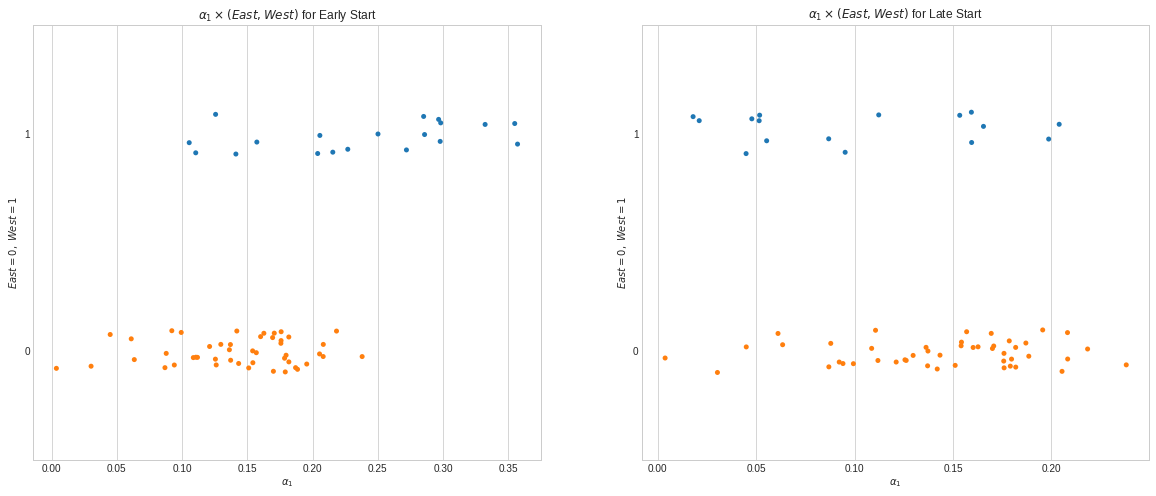

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
ax0 = sns.stripplot(ax = axes[0], y="D0G1", x="alpha_1", data=early_gr_df, jitter=True, orient="h", order=[1,0])
ax1 = sns.stripplot(ax = axes[1], y="D0G1", x="alpha_1", data=late_gr_df, jitter=True, orient="h", order=[1,0])

ax0.set_title(r'$\alpha_1 \times (East,West)$'+" for Early Start")
ax0.set_xlabel(r'$\alpha_1$')
ax0.set_ylabel(r'$East=0,\;West=1$')
ax1.set_title(r'$\alpha_1 \times (East,West)$'+" for Late Start")
ax1.set_xlabel(r'$\alpha_1$')
ax1.set_ylabel(r'$East=0,\;West=1$')

Computation of Logistic Model

In [ ]:
x=np.array(early_gr_df.alpha_1).reshape(-1,1)
y=early_gr_df.D0G1
early_lr = LogisticRegression(fit_intercept = True, C=1e9)
early_lr.fit(x, y)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
x=np.array(late_gr_df.alpha_1).reshape(-1,1)
y=late_gr_df.D0G1
late_lr = LogisticRegression(fit_intercept = True, C=1e9)
late_lr.fit(x, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Plot the Logistic curve

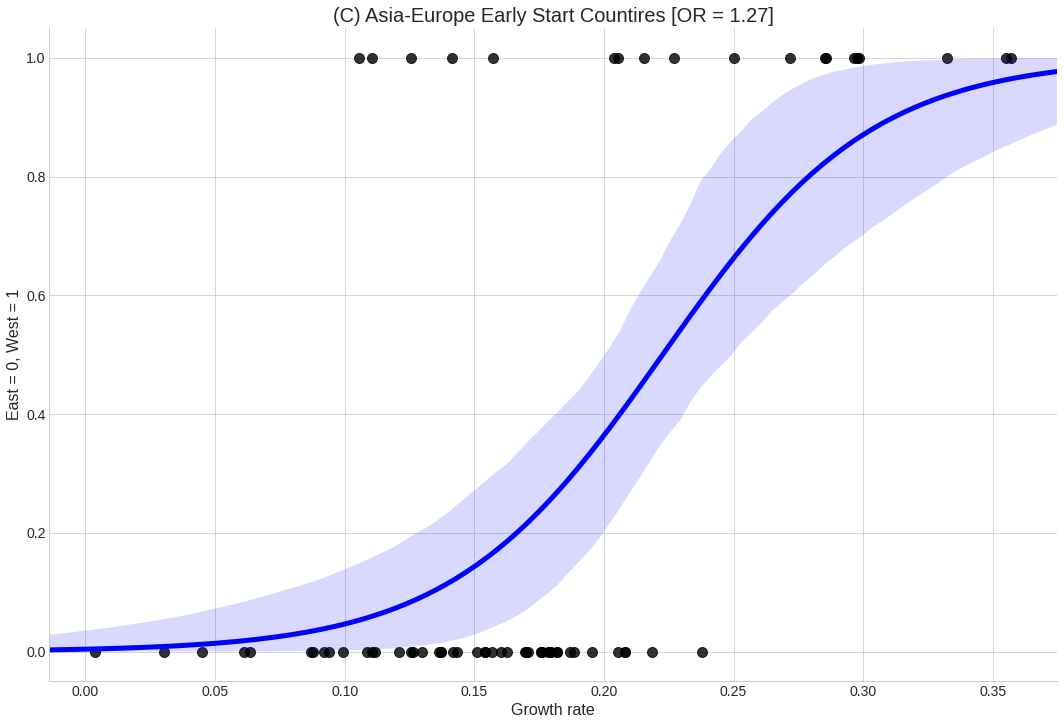

In [ ]:
plt.style.use('seaborn-whitegrid')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

lm = sns.lmplot(y="D0G1", x="alpha_1", data=early_gr_df, logistic=True, height=10, aspect=1.5, truncate=False, line_kws={'color':'blue',"lw":5}, scatter_kws={'color': 'black', "s": 100})

#X_test = np.linspace(-0.01, 0.45, 300)
#loss = expit(X_test * early_lr.coef_ + early_lr.intercept_).ravel()
#plt.plot(X_test, loss, color='red', linewidth=3)

plt.title("(C) Asia-Europe Early Start Countires [OR = 1.27]")
plt.xlabel("Growth rate")
plt.ylabel("East = 0, West = 1")
plt.show()



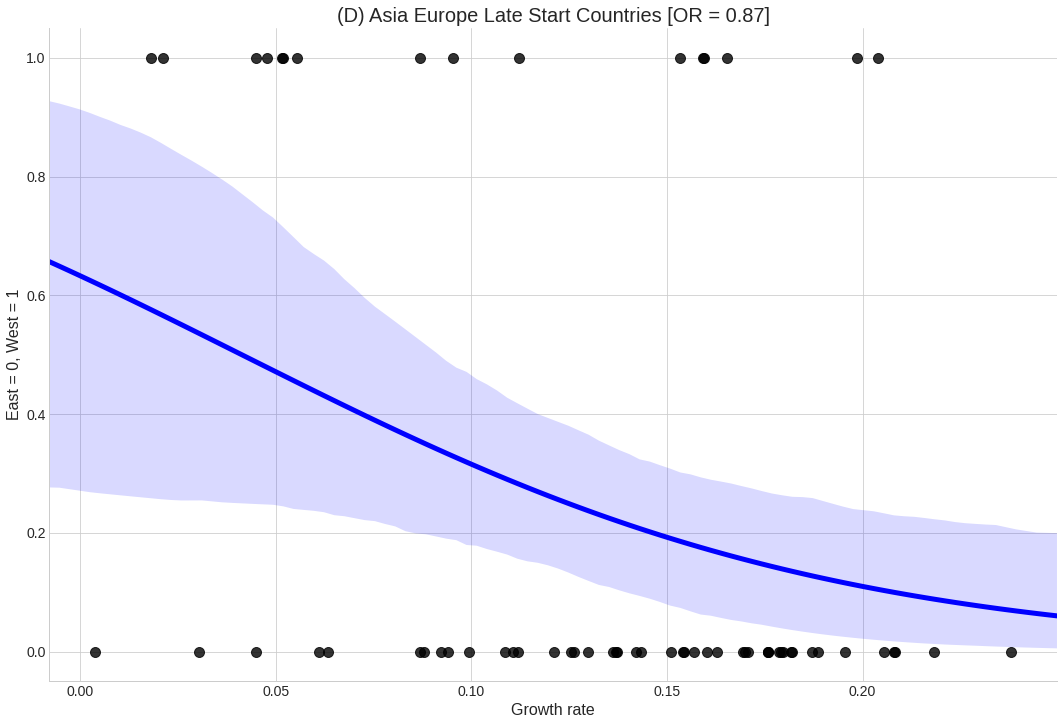

In [ ]:
plt.style.use('seaborn-whitegrid')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

lm = sns.lmplot(y="D0G1", x="alpha_1", data=late_gr_df, logistic=True, height=10, aspect=1.5, truncate=False, line_kws={'color':'blue',"lw":5}, scatter_kws={'color': 'black', "s": 100})

#X_test = np.linspace(-0.01, 0.45, 300)
#loss = expit(X_test * early_lr.coef_ + early_lr.intercept_).ravel()
#plt.plot(X_test, loss, color='red', linewidth=3)

plt.title("(D) Asia Europe Late Start Countries [OR = 0.87]")
plt.xlabel("Growth rate")
plt.ylabel("East = 0, West = 1")
plt.show()


## Computation of the summary statistics of Logistic Model

In [ ]:
# Function for the computation of summary statistics of Logistic Model
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

Print summary statistics

In [ ]:
# Print p-value, corrected Log OR and corrected OR
print("Statistics of the Slope from the Logistic Model:")
print("p-value: ",logit_pvalue(early_lr, np.array(early_gr_df.alpha_1).reshape(-1,1))[1])
print("Corrected Log OR: ",early_lr.coef_[0][0]/100)
print("Corrected OR: ",np.exp(early_lr.coef_[0][0]/100))
print("\n")

# Compare with statsmodels with re-scaled (100x) data
import statsmodels.api as sm
sm_model = sm.Logit(early_gr_df.D0G1, sm.add_constant(100*np.array(early_gr_df.alpha_1).reshape(-1,1))).fit(disp=0)
print("P-values of the model with re-scaled data:")
print(sm_model.pvalues)
print("\n")
sm_model.summary()


Statistics of the Slope from the Logistic Model:
p-value:  0.00019908342933350198
Corrected Log OR:  0.24640183910556546
Corrected OR:  1.2794135886712514


P-values of the model with re-scaled data:
const    0.000027
x1       0.000199
dtype: float64




<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   D0G1   No. Observations:                   66
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Aug 2020   Pseudo R-squ.:                  0.3220
Time:                        20:51:21   Log-Likelihood:                -26.860
converged:                       True   LL-Null:                       -39.616
Covariance Type:            nonrobust   LLR p-value:                 4.397e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4858      1.308     -4.195      0.000      -8.049      -2.923
x1             0.2464      0.066      3.720      0.000       0.117       0.376
==============================================================================
"""

In [ ]:
# Print p-value, corrected Log OR and corrected OR
print("Statistics of the Slope from the Logistic Model:")
print("p-value: ",logit_pvalue(late_lr, np.array(late_gr_df.alpha_1).reshape(-1,1))[1])
print("Corrected Log OR: ",late_lr.coef_[0][0]/100)
print("Corrected OR: ",np.exp(late_lr.coef_[0][0]/100))
print("\n")

# Compare with statsmodels with re-scaled (100x) data
import statsmodels.api as sm
sm_model = sm.Logit(late_gr_df.D0G1, sm.add_constant(100*np.array(late_gr_df.alpha_1).reshape(-1,1))).fit(disp=0)
print("P-values of the model with re-scaled data:")
print(sm_model.pvalues)
print("\n")
sm_model.summary()


Statistics of the Slope from the Logistic Model:
p-value:  0.015565691004993498
Corrected Log OR:  -0.13183780664610892
Corrected OR:  0.8764831432919535


P-values of the model with re-scaled data:
const    0.434582
x1       0.015566
dtype: float64




<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   D0G1   No. Observations:                   63
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Aug 2020   Pseudo R-squ.:                 0.08950
Time:                        20:51:26   Log-Likelihood:                -32.504
converged:                       True   LL-Null:                       -35.699
Covariance Type:            nonrobust   LLR p-value:                   0.01148
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5442      0.696      0.781      0.435      -0.821       1.909
x1            -0.1318      0.055     -2.419      0.016      -0.239      -0.025
==============================================================================
"""

In [ ]:
early_p_gr_df = pd.DataFrame(lst1_p, columns=['p','R'])
late_p_gr_df = pd.DataFrame(lst2_p, columns=['p','R'])


early_p_gr_df.drop(early_p_gr_df.loc[early_p_gr_df['R']<0.6].index, inplace=True)
late_p_gr_df.drop(late_p_gr_df.loc[late_p_gr_df['R']<0.6].index, inplace=True)

Text(0, 0.5, '$-\\log_{10}(p)$')

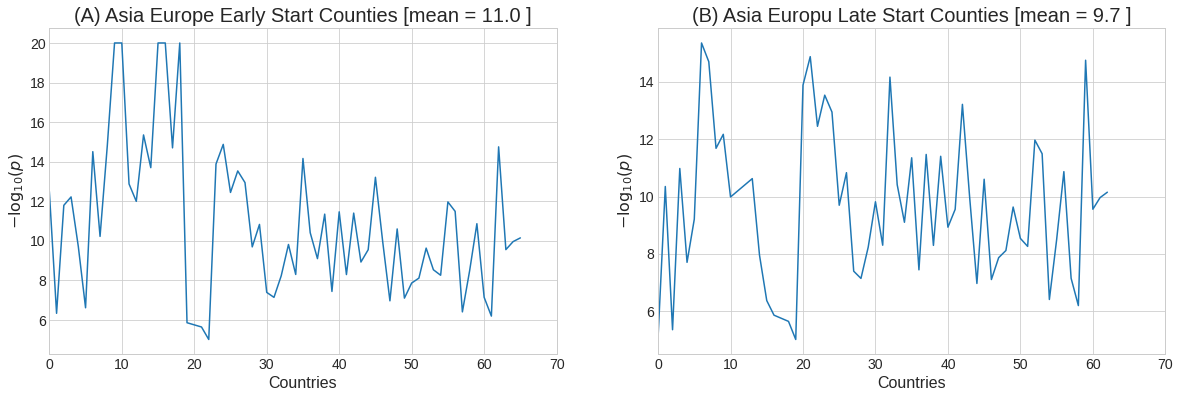

In [ ]:
plt.rcParams['figure.figsize'] = (20,6)
plt.style.use('seaborn-whitegrid')

x = np.round(np.mean(-np.log10(early_p_gr_df.p.replace(0, 1e-20))),1)
y = np.round(np.mean(-np.log10(late_p_gr_df.p.replace(0, 1e-20))),1)

plt.subplot(1, 2, 1)
plt.xlim(0,70)
plt.title('(A) Asia Europe Early Start Counties [mean = '+str(x)+' ]')
plt.plot(-np.log10(early_p_gr_df.p.replace(0, 1e-20)))
plt.xlabel("Countries")
plt.ylabel(r'$-\log_{10}(p)$')

plt.subplot(1, 2, 2)
plt.xlim(0,70)
plt.title('(B) Asia Europu Late Start Counties [mean = '+str(y)+' ]')
plt.plot(-np.log10(late_p_gr_df.p.replace(0, 1e-20)))
plt.xlabel("Countries")
plt.ylabel(r'$-\log_{10}(p)$')

Text(0, 0.5, '$R^2$')

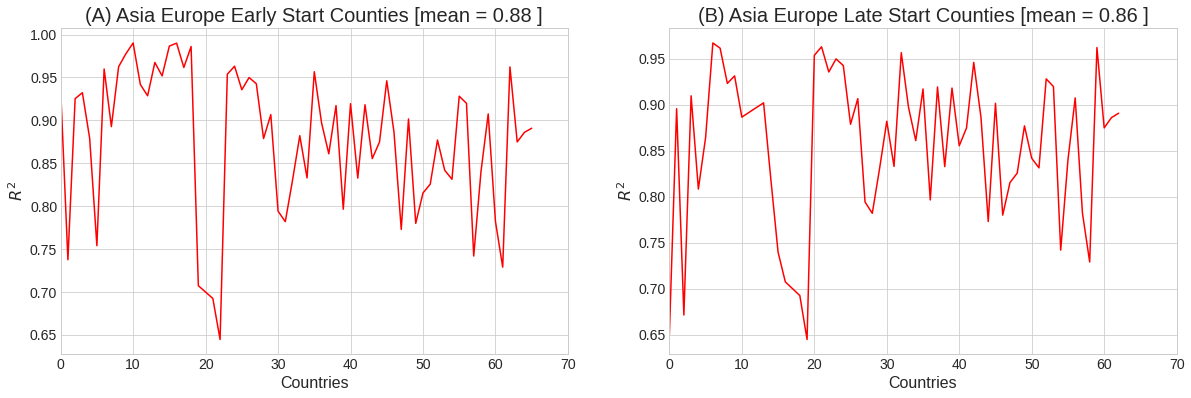

In [ ]:
plt.rcParams['figure.figsize'] = (20,6)
plt.style.use('seaborn-whitegrid')

x = np.round(np.mean(early_p_gr_df.R),2)
y = np.round(np.mean(late_p_gr_df.R),2)

plt.subplot(1, 2, 1)
plt.xlim(0,70)
plt.title('(A) Asia Europe Early Start Counties [mean = '+str(x)+' ]')
plt.plot(early_p_gr_df.R, color='red')
plt.xlabel("Countries")
plt.ylabel(r'$R^2$')

plt.subplot(1, 2, 2)
plt.xlim(0,70)
plt.title('(B) Asia Europe Late Start Counties [mean = '+str(y)+' ]')
plt.plot(late_p_gr_df.R, color='red')
plt.xlabel("Countries")
plt.ylabel(r'$R^2$')